In [3]:
# clear all jupyter variable 
%reset -f

### Input

- **Load directly pre-saved `pyg_graph`** to skip time-consuming Cell 15 (dataset generation for GNN training).
- **Load pre-trained model** to skip time-consuming Cells 20 & 21 (tuning and training the GNN model).


In [1]:
do_load_PyG = True
do_load_pre_trained_model = True

### Cell 1: Imports & constants

In [2]:

import os
import pickle
from pathlib import Path
from collections import defaultdict
from math import radians, sin, cos, atan2, sqrt, ceil
from typing import Optional, Tuple, List

import numpy as np
import networkx as nx
import multiprocessing as mp
import networkx as nx
import folium
from branca.colormap import linear as cm_linear
import pandas as pd
from pandas.io.excel import ExcelWriter

import torch
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv

import optuna
from tqdm.auto import tqdm

mp.set_start_method('fork', force=True)

# Paths
DATA_DIR   = Path("../data/processed")
MODEL_DIR = Path("../models")
GPS_CSV    = DATA_DIR / "gps_locations.csv"
INTER_CSV  = DATA_DIR / "interstation_connectivity.csv"
OD_CSV     = DATA_DIR / "passenger_flow.csv"
GPICKLE    = DATA_DIR / "paris_metro_linegraph.gpickle"
pyg_graph_path = DATA_DIR / "pyg_graphs.pkl"
gnn_model_path = MODEL_DIR / "gnn_optuna.pt"


OUT_DIR = Path("../results/top300")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Parameters
AVG_SPEED_KMPH   = 35.0
TRANSFER_PENALTY = 2.0
TRAIN_CAPACITY   = 900
MIN_HEADWAY_SEC  = 90



# Check if pre-saved PyG graph exists
if pyg_graph_path.exists():
    # Proceed with loading the graph
    print("Pre-saved PyG graph found. Proceeding...")
    # Your code to load the graph goes here
else:
    # Raise an error with instructions
    raise FileNotFoundError(
        "Pre-saved PyG graph not found. "
        "Set `do_load_PyG = True` to generate training data from scratch."
    )

# Check for pre-trained model file
if gnn_model_path.exists():
    print("Pre-trained GNN model found. Proceeding...")
    # Load model or related logic
elif do_load_pre_trained_model:
    # Raise an error with instructions
    raise FileNotFoundError(
        "Pre-trained GNN model not found. "
        "Set `do_load_pre_trained_modelG = True` to tune and train from scratch."
    )
else:
    print('Pre-trained model not found. Train the model. Proceeding...')
    

Pre-saved PyG graph found. Proceeding...
Pre-trained GNN model found. Proceeding...


### Cell 2: Geo‐spatial helpers

In [120]:

R_EARTH_KM = 6371.0

def haversine_km(p1, p2):
    lat1, lon1 = p1; lat2, lon2 = p2
    φ1, φ2 = radians(lat1), radians(lat2)
    dφ, dλ = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dφ/2)**2 + cos(φ1)*cos(φ2)*sin(dλ/2)**2
    return 2 * R_EARTH_KM * atan2(sqrt(a), sqrt(1 - a))

def time_min(dist_km):
    return dist_km / AVG_SPEED_KMPH * 60

### Cell 3: build_line_graph()

In [121]:

def build_line_graph():
    # load station coords
    gps = (
        pd.read_csv(GPS_CSV, encoding="utf-8-sig")
          .assign(lat=lambda df: df.GPS.str.split(',',expand=True)[0].astype(float),
                  lon=lambda df: df.GPS.str.split(',',expand=True)[1].astype(float))
          .set_index("Station")
    )

    inter = (
        pd.read_csv(INTER_CSV, encoding="utf-8-sig")
          .rename(columns={
            "de Ligne":"line_from","de Station":"station_from",
            "vers Ligne":"line_to","vers Station":"station_to"
          })
    )

    G = nx.MultiDiGraph()

    # 1) nodes = station|line
    for _, r in inter.iterrows():
        for st, ln in [(r.station_from, r.line_from),(r.station_to, r.line_to)]:
            nid = f"{st}|{ln}"
            if nid not in G:
                G.add_node(nid,
                           station=st, line=ln,
                           lat=gps.at[st,"lat"],
                           lon=gps.at[st,"lon"])
    # 2) RUN edges along same line
    for _, r in inter.iterrows():
        if r.line_from==r.line_to and r.station_from!=r.station_to:
            u = f"{r.station_from}|{r.line_from}"
            v = f"{r.station_to}|{r.line_to}"
            t = time_min(haversine_km((G.nodes[u]["lat"],G.nodes[u]["lon"]),
                                      (G.nodes[v]["lat"],G.nodes[v]["lon"])))
            # bidirectional
            G.add_edge(u,v, travel_time=t, type="RUN", load=0.0)
            G.add_edge(v,u, travel_time=t, type="RUN", load=0.0)
    # 3) TRANSFER edges at same station
    groups = defaultdict(list)
    for n,d in G.nodes(data=True):
        groups[d["station"]].append(n)
    for st, nodes in groups.items():
        walk = len(nodes) + len(nodes)/2 + TRANSFER_PENALTY
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                u,v = nodes[i], nodes[j]
                G.add_edge(u,v, travel_time=walk, type="TRANSFER", station=st, load=0.0)
                G.add_edge(v,u, travel_time=walk, type="TRANSFER", station=st, load=0.0)

    # cache
    with open(GPICKLE, "wb") as f:
        pickle.dump(G, f)
    return G

### Cell 4: load (or build) the graph

In [122]:

if GPICKLE.exists():
    with open(GPICKLE, "rb") as f:
        LG = pickle.load(f)
else:
    LG = build_line_graph()

print(f"Loaded graph with {LG.number_of_nodes()} nodes, {LG.number_of_edges()} edges")

Loaded graph with 397 nodes, 2204 edges


### Cell 5: station→nodes index & heuristic

In [123]:

# map logical station to all line‐nodes
station_to_nodes = defaultdict(list)
for n,d in LG.nodes(data=True):
    station_to_nodes[d["station"]].append(n)

# admissible heuristic for A*
def heuristic(u,v):
    pu = (LG.nodes[u]["lat"], LG.nodes[u]["lon"])
    pv = (LG.nodes[v]["lat"], LG.nodes[v]["lon"])
    return time_min(haversine_km(pu, pv))

In [124]:

def build_station_index(G):
    idx = defaultdict(list)
    for n, d in G.nodes(data=True):
        idx[d['station']].append(n)
    return idx

### Cell 6: Find shortest path/cost between two stations

In [125]:

def best_path(
    G: nx.MultiDiGraph,
    station_idx: dict[str, list[str]],
    heuristic: callable,
    src_station: str,
    dst_station: str
) -> Optional[Tuple[List[str], float]]:
    """Find the shortest path (and cost) between two station‐names on graph G."""
    best_cost, best_path = float('inf'), None

    if src_station not in station_idx or dst_station not in station_idx:
        return None

    for u in station_idx[src_station]:
        for v in station_idx[dst_station]:
            try:
                p = nx.astar_path(G, u, v, heuristic=heuristic, weight='travel_time')
                # sum up travel_time using the same keys as the path
                c = sum(
                    next(iter(G[a][b].values()))['travel_time']
                    for a,b in zip(p[:-1], p[1:])
                )
                if c < best_cost:
                    best_cost, best_path = c, p
            except (nx.NetworkXNoPath, KeyError):
                continue

    if best_path is None:
        return None
    return best_path, best_cost

### Cell 7: assign_flows with full edge removal up front

In [126]:

def assign_flows(G: nx.MultiDiGraph, od_df: pd.DataFrame, scenario=None):
    # 1) copy graph and apply the scenario
    G2 = G.copy()
    if scenario:
        kind, descr = scenario
        if kind == "edge":
            u, v, _ = descr
            # remove every RUN edge between u<->v in both directions, up front
            for a, b in [(u, v), (v, u)]:
                if G2.has_edge(a, b):
                    for key in list(G2[a][b].keys()):
                        if G2[a][b][key].get("type") == "RUN":
                            G2.remove_edge(a, b, key=key)

        else:  # station closure
            st, = descr
            to_remove = [n for n, d in G2.nodes(data=True) if d["station"] == st]
            G2.remove_nodes_from(to_remove)

    # 2) rebuild station index & heuristic for G2
    idx2 = build_station_index(G2)
    def h2(u, v):
        pu = (G2.nodes[u]["lat"], G2.nodes[u]["lon"])
        pv = (G2.nodes[v]["lat"], G2.nodes[v]["lon"])
        return time_min(haversine_km(pu, pv))

    # 3) reset loads & prepare travel_times
    for _, _, _, d in G2.edges(keys=True, data=True):
        d["load"] = 0.0
    travel_times = {}

    # 4) push OD flows (now on the truly degraded graph)
    for _, row in od_df.iterrows():
        o, dest, pax = row.origin, row.dest, float(row.pax)
        if pax <= 0 or o == dest:
            continue
        res = best_path(G2, idx2, h2, o, dest)
        if res is None:
            continue
        path, tt = res
        travel_times[(o, dest)] = tt
        for a, b in zip(path[:-1], path[1:]):
            for attrs in G2[a][b].values():
                attrs["load"] += pax

    # 5) aggregate line_loads & headways
    line_load = defaultdict(list)
    max_load  = 0.0
    for u, v, k, d in G2.edges(keys=True, data=True):
        if d.get("type") == "RUN" and d["load"] > 0:
            ln = G2.nodes[u]["line"]
            s1 = G2.nodes[u]["station"]; s2 = G2.nodes[v]["station"]
            line_load[ln].append((s1, s2, d["load"]))
            max_load = max(max_load, d["load"])

    headways = []
    for ln, segs in line_load.items():
        peak = max(l for *_, l in segs)
        tph  = ceil(peak / TRAIN_CAPACITY)
        hsec= max(MIN_HEADWAY_SEC, 3600/max(tph,1))
        headways.append(dict(line=ln, peak_load=peak, tph=tph, headway_sec=hsec))

    return dict(
        G=G2,
        line_load=line_load,
        max_load=max_load,
        headways=headways,
        travel_times=travel_times
    )

### Cell 8: load OD matrix & compute baseline

In [127]:

od_df = (
    pd.read_csv(OD_CSV, encoding="utf-8-sig")
      .rename(columns={"de":"origin","vers":"dest","nombre":"pax"})
)
baseline = assign_flows(LG, od_df)
print("Baseline: max_segment_load =", baseline["max_load"])

Baseline: max_segment_load = 27010.0


### Cell 9: scenario generation & scoring

In [128]:

# Edge‐failures that are bypassable
def alternative_exists(G,u,v):
    try:
        nx.shortest_path(G,u,v,weight="travel_time")
        return True
    except: return False

edge_scens = []
for u,v,k,d in LG.edges(keys=True, data=True):
    if d["type"]!="RUN": continue
    Gtmp = LG.copy(); Gtmp.remove_edge(u,v,key=k)
    if alternative_exists(Gtmp,u,v):
        edge_scens.append(("edge",(u,v,k)))

# Station closures that are bypassable
station_scens = []
for st in set(d["station"] for _,d in LG.nodes(data=True)):
    nodes = [n for n,d in LG.nodes(data=True) if d["station"]==st]
    Gtmp = LG.copy(); Gtmp.remove_nodes_from(nodes)
    # naive check: graph stays connected among remaining nodes
    if nx.is_weakly_connected(Gtmp):
        station_scens.append(("station",(st,)))

print(f"{len(edge_scens)} edge scenarios, {len(station_scens)} station scenarios")

# Score = Δmax_load (naive metric here)
# scored = []
# for sc in edge_scens[:1] + station_scens[:1]:  # pick a few
#     res = assign_flows(LG, od_df, scenario=sc)
#     delta = res["max_load"] - baseline["max_load"]
#     scored.append((sc, delta))
# scored.sort(key=lambda x: x[1], reverse=True)
# scored

1960 edge scenarios, 202 station scenarios


### Cell 10: pick unique physical segments

In [129]:

# 1) Compute baseline load per directed edge
baseline_loads = {
    (u, v, k): d["load"]
    for u, v, k, d in baseline["G"].edges(keys=True, data=True)
    if d["type"] == "RUN"
}

# 2) Deduplicate so we only keep one scenario per physical segment
unique_scens = []
seen = set()
for kind, (u, v, k) in edge_scens:
    # identify the segment by line + unordered station pair
    ln = LG.nodes[u]["line"]
    st1 = LG.nodes[u]["station"]
    st2 = LG.nodes[v]["station"]
    seg_id = (ln, tuple(sorted([st1, st2])))
    if seg_id in seen:
        continue
    seen.add(seg_id)
    unique_scens.append((kind, (u, v, k)))

# 3) Sort those unique scenarios by their baseline load (descending)
edge_only_sorted = sorted(
    unique_scens,
    key=lambda sc: baseline_loads.get(sc[1], 0.0),
    reverse=True
)

# 4) Take the top 300
top300 = edge_only_sorted[:300]

# Quick sanity check
loads = [baseline_loads.get(sc[1], 0) for sc in top300]
print(f"Selected top {len(top300)} unique edge degradations, load range {min(loads):.1f}–{max(loads):.1f} pax/h")

Selected top 300 unique edge degradations, load range 5926.0–26795.0 pax/h


### Cell 11: Updated render_heatmap to draw station nodes

In [130]:

def render_heatmap_with_nodes(res, scenario=None, title="Heatmap"):
    """
    Draws:
      • station nodes as small circles
      • coloured RUN‐edge flows
      • (optional) highlight for removed edge/station
    """
    G2        = res['G']
    line_load = res['line_load']
    max_load  = res['max_load']
    colormap  = cm_linear.YlOrRd_09.scale(0, max_load or 1).to_step(9)

    # base map
    m = folium.Map(location=[48.8566, 2.3522], zoom_start=12,
                   tiles="cartodbpositron")

    # 1) draw all stations as small grey circles
    for n, d in G2.nodes(data=True):
        folium.CircleMarker(
            location=(d['lat'], d['lon']),
            radius=3,
            color='gray',
            fill=True,
            fill_opacity=0.7,
            weight=0
        ).add_to(m)

    # 2) draw RUN‐edge flows
    for ln, segs in line_load.items():
        for s1, s2, l in segs:
            u, v = f"{s1}|{ln}", f"{s2}|{ln}"
            folium.PolyLine(
                [(G2.nodes[u]["lat"], G2.nodes[u]["lon"]),
                 (G2.nodes[v]["lat"], G2.nodes[v]["lon"])],
                weight=2 + 6 * (l / max_load if max_load else 0),
                color=colormap(l),
                tooltip=f"{s1}→{s2} (Line {ln}): {l:.0f} pax/h"
            ).add_to(m)

    # 3) highlight removed element (if any)
    if scenario is not None:
        kind, descr = scenario
        if kind == 'edge':
            u, v, _ = descr
            lat1, lon1 = G2.nodes[u]['lat'], G2.nodes[u]['lon']
            lat2, lon2 = G2.nodes[v]['lat'], G2.nodes[v]['lon']
            mid = [(lat1 + lat2) / 2, (lon1 + lon2) / 2]
            folium.CircleMarker(
                location=mid,
                radius=8,
                color='black',
                fill=True,
                fill_opacity=0.7,
                tooltip="Removed segment"
            ).add_to(m)
        else:  # station scenario (not used here)
            st, = descr
            for n, d in G2.nodes(data=True):
                if d['station'] == st:
                    folium.CircleMarker(
                        location=(d['lat'], d['lon']),
                        radius=64,
                        color='black',
                        fill=True,
                        fill_opacity=0.1,
                        tooltip=f"Closed station: {st}"
                    ).add_to(m)

    # 4) add colormap caption
    colormap.caption = title
    colormap.add_to(m)
    return m

### Cell 12: Save baseline network map for comparison

In [ ]:

# ensure OUT_DIR is defined
baseline_res = assign_flows(LG, od_df, scenario=None)
m0 = render_heatmap_with_nodes(baseline_res, scenario=None, title="Baseline Network")
m0.save(OUT_DIR / "000_baseline.html")

### Cell 13: Pick top 15 sample for experimentation

In [131]:
top15 = edge_only_sorted[:15]
print("Top-15 scenarios:", [
    (LG.nodes[u]["station"], LG.nodes[v]["station"], baseline_loads[(u,v,k)])
    for _, (u,v,k) in top15
])

Top-15 scenarios: [('Châtelet', 'Cité', 26795.0), ('Cité', 'Saint-Michel', 26193.0), ('Odéon', 'Saint-Michel', 25842.0), ('Saint-Lazare', 'Havre - Caumartin', 23763.0), ('Montparnasse - Bienvenüe', 'Edgar Quinet', 22346.0), ('Bastille', 'Ledru-Rollin', 22098.0), ('Raspail', 'Edgar Quinet', 21306.0), ('Hôtel de Ville', 'Saint-Paul', 21174.0), ('Ledru-Rollin', 'Faidherbe - Chaligny', 20961.0), ('Châtelet', 'Hôtel de Ville', 20502.0), ('Bastille', 'Saint-Paul', 20447.0), ('Bastille', 'Bastille', 20122.0), ('Châtelet', 'Les Halles', 20088.0), ('Reuilly - Diderot', 'Faidherbe - Chaligny', 19827.0), ("Gare de l'Est", 'Château-Landon', 19734.0)]


### Cell 14: Fixed graph_to_pyg

In [132]:

def graph_to_pyg(res: dict) -> Data:
    """
    Convert the output of assign_flows (a dict with G, line_load, max_load, headways, travel_times)
    into a PyG Data object with:
      - x: node features [in_deg, out_deg, lat, lon]
      - edge_index: 2 x E tensor
      - edge_attr: E x 3 tensor [travel_time, is_RUN, is_TRANSFER]
      - y: E-length tensor of log1p(load)
    """
    G2 = res["G"]
    # Node indexing
    node_idx = {n: i for i, n in enumerate(G2.nodes())}
    # Node features
    x = torch.tensor([
        [G2.in_degree(n), G2.out_degree(n), d["lat"], d["lon"]]
        for n, d in G2.nodes(data=True)
    ], dtype=torch.float)

    edge_index = []
    edge_attr  = []
    loads      = []

    for u, v, k, d in G2.edges(keys=True, data=True):
        # build edge_index
        edge_index.append([node_idx[u], node_idx[v]])
        # build edge_attr
        edge_attr.append([
            d.get("travel_time", 0.0),
            1.0 if d.get("type") == "RUN" else 0.0,
            1.0 if d.get("type") == "TRANSFER" else 0.0,
        ])
        # collect the scalar load
        loads.append(d.get("load", 0.0))

    # Convert lists to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr  = torch.tensor(edge_attr, dtype=torch.float)
    y          = torch.log1p(torch.tensor(loads, dtype=torch.float))

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

### Cell 15: Score & export top-300 + collect PyG graphs

In [133]:
if not do_load_PyG:

    ENGINE = "openpyxl"  # or "xlsxwriter"

    # Precompute baseline stats
    base_max_load = baseline["max_load"]
    base_head_min = min(h["headway_sec"] for h in baseline["headways"])
    base_mean_tt  = np.mean(list(baseline["travel_times"].values()))

    summary_records = []
    pyg_graphs     = []

    for idx, scenario in enumerate(tqdm(top300, desc="scoring scenarios"), start=1):
        _, (u, v, _) = scenario

        # 1) reroute flows
        res = assign_flows(LG, od_df, scenario)

        # 2) derive station names for filename
        stn1 = LG.nodes[u]["station"].replace(" ", "_")
        stn2 = LG.nodes[v]["station"].replace(" ", "_")
        base = f"{idx:03d}_degraded_map_{stn1}_{stn2}"

        # 3) compute metrics
        scen_max_load = res["max_load"]
        scen_head_min = min(h["headway_sec"] for h in res["headways"])
        scen_mean_tt  = np.mean(list(res["travel_times"].values()))

        summary_records.append({
            "scenario_id":       idx,
            "segment":           f"{stn1}–{stn2}",
            "baseline_max_load": base_max_load,
            "scenario_max_load": scen_max_load,
            "delta_max_load":    scen_max_load - base_max_load,
            "baseline_mean_TT":  base_mean_tt,
            "scenario_mean_TT":  scen_mean_tt,
            "delta_mean_TT":     scen_mean_tt - base_mean_tt,
            "baseline_min_head": base_head_min,
            "scenario_min_head": scen_head_min,
            "delta_min_head":    scen_head_min - base_head_min,
        })

        # 4) collect PyG Data for ML
        pyg_graphs.append(graph_to_pyg(res))

        # 5) save Folium map
        m = render_heatmap_with_nodes(res, scenario, title=base)
        m.save(OUT_DIR / f"{base}.html")

        # 6) save single Excel with 3 sheets
        excel_path = OUT_DIR / f"{base}.xlsx"
        with ExcelWriter(excel_path, engine=ENGINE) as writer:
            # a) one sheet per line
            for line, segs in res["line_load"].items():
                pd.DataFrame(segs, columns=["from_station","to_station","pax_per_h"]) \
                .to_excel(writer, sheet_name=f"Line_{line}", index=False)

            # b) headways sheet
            pd.DataFrame(res["headways"]) \
            .to_excel(writer, sheet_name="Headways", index=False)

            # c) OD_TT sheet
            rows = []
            for (o, d), base_tt in baseline["travel_times"].items():
                deg_tt = res["travel_times"].get((o, d), None)
                rows.append({
                    "origin":      o,
                    "dest":        d,
                    "baseline_tt": base_tt,
                    "degraded_tt": deg_tt,
                    "delta_tt":    (deg_tt - base_tt) if deg_tt is not None else None
                })
            pd.DataFrame(rows).to_excel(writer, sheet_name="OD_TT", index=False)

        if idx % 50 == 0:
            print(f"  • Completed {idx}/{len(top300)}")

    df_summary = pd.DataFrame(summary_records)
    summary_path = OUT_DIR / "scenario_summary.xlsx"
    df_summary.to_excel(summary_path, index=False)
    print(f"Saved summary of {len(df_summary)} scenarios to {summary_path}")

### Cell 16: build your PyG Dataset & DataLoader


In [134]:

if do_load_PyG:
    with open('../data/processed/pyg_graphs.pkl', 'rb') as f:
        pyg_graphs = pickle.load(f)


class DegradationDataset(Dataset):
    def __init__(self, graphs):
        super().__init__(root=None)
        self.graphs = graphs
    def len(self):
        return len(self.graphs)
    def get(self, idx):
        return self.graphs[idx]

dataset = DegradationDataset(pyg_graphs)
loader  = DataLoader(dataset, batch_size=4, shuffle=True)


### Cell 17: Setup device

In [135]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print("Using device:", device)



Using device: cuda


### Cell 18: Split dataset into train/val/test

In [136]:

# assume `dataset` from previous cell has length N
N = len(dataset)
n_train = int(0.7 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test],
                                         generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False)

print(f"Splits: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

Splits: train=210, val=45, test=45


### Cell 19: Define Optuna objective

In [137]:

def objective(trial):
    # hyperparameters to tune
    hidden = trial.suggest_int("hidden", 32, 256, step=32)
    lr     = trial.suggest_float("lr", 1e-4, 1e-2, log = True)
    num_layers = trial.suggest_int("num_layers", 1, 3)

    # build model
    class TunedGNN(torch.nn.Module):
        def __init__(self):
            super().__init__()
            layers = []
            in_feats = 4
            for i in range(num_layers):
                out_feats = hidden if i < num_layers-1 else hidden
                layers.append(GraphConv(in_feats, out_feats))
                in_feats = out_feats
            self.convs = torch.nn.ModuleList(layers)
            self.edge_mlp = torch.nn.Sequential(
                torch.nn.Linear(3 + 2*hidden, hidden),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden, 1)
            )

        def forward(self, x, edge_index, edge_attr):
            h = x.to(device)
            for conv in self.convs:
                h = F.relu(conv(h, edge_index.to(device)))
            src, dst = edge_index
            z = torch.cat([edge_attr.to(device), h[src], h[dst]], dim=1)
            return self.edge_mlp(z).squeeze()

    model = TunedGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # training loop
    for epoch in range(1, 1001):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = F.mse_loss(pred, batch.y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr)
                val_loss += F.mse_loss(pred, batch.y).item()
        # report intermediate for pruning
        trial.report(val_loss / len(val_loader), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return val_loss / len(val_loader)

### Cell 20: Run Optuna study
Skip cell 20 and 21 if want to use a pre-trained model

In [138]:
if not do_load_pre_trained_model:
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=30, timeout=3600, show_progress_bar=True)

    print("Best trial:")
    best = study.best_trial
    print(f"  Value: {best.value:.4f}")
    print("  Params:")
    for k,v in best.params.items():
        print(f"    {k}: {v}")

### Cell 21: Train final model on best params and test or load pre-trained model

In [139]:

# build final model class as in objective
class FinalGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        in_feats = 4
        for i in range(num_layers):
            layers.append(GraphConv(in_feats, hidden))
            in_feats = hidden
        self.convs = torch.nn.ModuleList(layers)
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(3 + 2 * hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        h = x.to(device)
        for conv in self.convs:
            h = F.relu(conv(h, edge_index.to(device)))
        src, dst = edge_index
        z = torch.cat([edge_attr.to(device), h[src], h[dst]], dim=1)
        return self.edge_mlp(z).squeeze()
    
if do_load_pre_trained_model:
    checkpoint = torch.load("../models/gnn_optuna.pt", map_location=device, weights_only=False)

    hidden = checkpoint["config"]["hidden"]
    num_layers = checkpoint["config"]["num_layers"]

    # Rebuild the model with the correct structure
    model = FinalGNN().to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
else:
    # extract best params
    # hidden     = best.params["hidden"]
    # lr         = best.params["lr"]
    # num_layers = best.params["num_layers"]
    hidden     = 96
    lr         = 0.0004994
    num_layers = 2
    model = FinalGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train on combined train+val
    combined_loader = DataLoader(train_ds + val_ds, batch_size=4, shuffle=True)
    for epoch in tqdm(range(1, 2001), desc='Final Training:'):
        model.train()
        loss_acc = 0
        for batch in combined_loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = F.mse_loss(pred, batch.y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            loss_acc += loss.item()
        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch:02d} Train+Val MSE={loss_acc / len(combined_loader):.4f}")

    # evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            test_loss += F.mse_loss(pred, batch.y).item()
    print(f"Test MSE: {test_loss / len(test_loader):.4f}")


### Cell 21: Plot predicted vs. ground-truth loads for a scenario

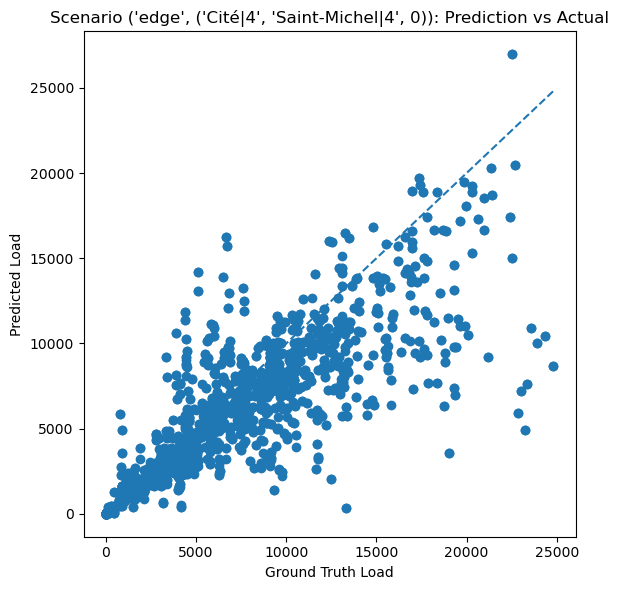

In [140]:
# 1) Pick your scenario list (top15 or top300) and scenario index
scenarios = top300   # or top300
scenario  = scenarios[1]   # change index as needed
res = assign_flows(LG, od_df, scenario)
true_loads = [d['load'] for _, _, _, d in res['G'].edges(keys=True, data=True)]

# 2) Predict using existing model and DataLoader
data = graph_to_pyg(res).to(device)
model.eval()
with torch.no_grad():
    pred_log = model(data.x, data.edge_index, data.edge_attr)
pred_loads = torch.expm1(pred_log).cpu().numpy()

# 3) Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(true_loads, pred_loads)
minv, maxv = min(true_loads), max(true_loads)
plt.plot([minv, maxv], [minv, maxv], '--')
plt.xlabel("Ground Truth Load")
plt.ylabel("Predicted Load")
plt.title(f"Scenario {scenario}: Prediction vs Actual")
plt.tight_layout()
plt.show()

### Cell 22: Visualise true vs predicted result

In [ ]:

# 2) Compute the degraded graph & extract RUN‐edges
G2     = res["G"]
edges  = [(u, v, k, d) for u, v, k, d in G2.edges(keys=True, data=True) if d["type"]=="RUN"]
true_l = np.array([d["load"] for _, _, _, d in edges])

# 3) Run the model to get predictions
data = graph_to_pyg(res).to(device)
model.eval()
with torch.no_grad():
    pred_log = model(data.x, data.edge_index, data.edge_attr)
pred_l = torch.expm1(pred_log).cpu().numpy()

# 4) Build a common color scale
max_load = max(true_l.max(), pred_l.max(), 1)
cmap     = cm_linear.YlOrRd_09.scale(0, max_load).to_step(9)

# 5) Initialize map and fit bounds to all station nodes
locs = [(d["lat"], d["lon"]) for _, d in G2.nodes(data=True)]
m = folium.Map(tiles="cartodbpositron")
m.fit_bounds(locs)

# 6) Plot each segment: first the true‐load in gray, then predicted in color
for i, (u, v, k, d) in enumerate(edges):
    pts = [(G2.nodes[u]["lat"], G2.nodes[u]["lon"]),
           (G2.nodes[v]["lat"], G2.nodes[v]["lon"])]
    t, p = true_l[i], pred_l[i]
    # ground truth in light gray
    folium.PolyLine(
        pts,
        weight=2 + 6*(t/max_load),
        color="lightgray",
        opacity=0.6
    ).add_to(m)
    # prediction overlay
    tooltip = (
        f"{G2.nodes[u]['station']} → {G2.nodes[v]['station']}<br>"
        f"<b>True</b>: {t:.0f} pax/h<br>"
        f"<b>Pred</b>: {p:.0f} pax/h"
    )
    folium.PolyLine(
        pts,
        weight=2 + 6*(p/max_load),
        color=cmap(p),
        opacity=0.9,
        tooltip=tooltip
    ).add_to(m)

# 7) Highlight the removed edge midpoint
u,v,_ = scenario[1]
mid = [(G2.nodes[u]["lat"]+G2.nodes[v]["lat"])/2,
       (G2.nodes[u]["lon"]+G2.nodes[v]["lon"])/2]
folium.CircleMarker(
    location=mid,
    radius=6,
    color="black",
    fill=True,
    fill_opacity=0.8,
    tooltip="Removed segment"
).add_to(m)

# 8) Add legend & display
cmap.caption = "Predicted pax/h"
cmap.add_to(m)
# to save: 
m.save(f"../results/pred_vs_true_scenario_{scenarios.index(scenario)+1}.html")
m  # in Jupyter this will display the map

### Cell: 23 Happy with results then save/update model and PyG file

In [141]:

# save/update final model
do_save_GNN_model = False

if do_save_GNN_model:
    # Save both model weights and metadata
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": {
            "hidden": hidden,
            "num_layers": num_layers,
            "lr": lr
        }
    }, "../models/gnn_optuna.pt")
    print("Saved tuned model to gnn_optuna.pt")


# save/update PyG
do_save_PyG = False

if do_save_PyG:
    save_path = Path("data/processed/pyg_graphs.pkl")
    with open(save_path, "wb") as f:
        pickle.dump(pyg_graphs, f)